In [1162]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import root
from datetime import datetime, timedelta


| Abbreviation | Meaning          |
|--------------|------------------|
| CD           | Current Date     |
| ID           | Issue Date       |
| MD           | Maturity Date    |
| LCD          | Last Coupon Date |
| NCD          | Next Coupon Date |
| DP           | Dirty Price      |
| CP           | Clean Price      |
| TTM          | Time to Maturity |
| T            | Time Periods     |
| FV           | Notional Amount  |
| CR           | Coupon Rate      |
| w            | Period till NCD  |
| n            | Period since LCD |
| AI           | Accrued Interest |


In [1163]:
# Bond selection based on payment schedule
selected_bonds = [
    'CA135087J546',
    'CA135087J967',
    'CA135087K528',
    'CA135087K940',
    'CA135087L518',
    'CA135087L930',
    'CA135087M847',
    'CA135087N837',
    'CA135087P576',
    'CA135087Q491',
    'CA135087Q988']

dates = [
    '2024-01-08',
    '2024-01-09',
    '2024-01-10',
    '2024-01-11',
    '2024-01-12',
    '2024-01-15',
    '2024-01-16',
    '2024-01-17',
    '2024-01-18',
    '2024-01-19']

In [1164]:
# read bond data csv file
data = pd.read_csv('APM466_Bond_Data.csv')

# filter the selected 10 bonds
# bonds = data[data['selected'] == 1]
data = data[data['ISIN'].isin(selected_bonds)]

In [1165]:
bonds = pd.DataFrame()

# convert values to ideal formats
bonds['date'] = pd.to_datetime(data['date'])
bonds['ISIN'] = data['ISIN']
bonds['MD'] = pd.to_datetime(data['maturity_date'])
bonds['CR'] = pd.to_numeric(data['coupon'].str.replace('%', ''))/100
bonds['CP'] = pd.to_numeric(data['close_price'])

# filter the target data-range
start_date = pd.to_datetime('2024-01-08')
end_date = pd.to_datetime('2024-01-19')
bonds = bonds[bonds['date'] >= start_date]
bonds = bonds[bonds['date'] <= end_date]

# print out the information available
information = bonds.columns.tolist()
print("Available Informations are:")
print(information)

print("===============================================================")

# double check selected 10 bond's ISIN #
bonds_copy = bonds
isin = bonds_copy['ISIN'].unique()
print("The 10 Bonds Selected for Constuction of the Yield Curve are:")
print(isin)

Available Informations are:
['date', 'ISIN', 'MD', 'CR', 'CP']
The 10 Bonds Selected for Constuction of the Yield Curve are:
['CA135087J546' 'CA135087J967' 'CA135087K528' 'CA135087K940'
 'CA135087L518' 'CA135087L930' 'CA135087M847' 'CA135087N837'
 'CA135087P576' 'CA135087Q491' 'CA135087Q988']


**Empirical Questions Implementation**  
**Section 2.2 4(a)**
1. Calculuate each of 10 selected bonds' yield(spot)
1. Provide a well-labeled plot with 5-year curve (spot curve) corresponding to each day of data superimposed on top of each other
1. Use any appropriate interpolation provided: Provide reasonable explanation for the technique used

In [1166]:
# quoted price are clean price
# calculate dirty price by adding the accrued interest on the coupon payments

def last_coupon(date, MD):
    # maturity date is on the 1st of the month
    # final coupon date is approximated to be at maturity (1 day before)
    # but all intermediate coupon payment date are on the 1st
    track = MD

    while (track - date).days > 1:
        track = track - pd.DateOffset(months=6)
    return track

def acc_int(date, LCD, CR, FV):
    # n = number of days since the last coupon payment
    n = (date - LCD).days
    interest = (n/365)*(FV*CR)
    return interest

def time_to_maturity(date, MD):
    n = (MD - date).days
    return n/365

def calculate_yield(ISIN, MD, CD, DP, TTM, FV, CR, LCD):

    # semi-annual coupon payments
    coupon = CR*FV/2
    # print("semi-annual coupon:", coupon)

    # Calculate Next Coupon Date
    NCD = LCD + pd.DateOffset(months=6)
    w = (NCD-CD).days / 365
    # print("next coupon date:", NCD)

    # If Mature within 6M: 
    if TTM <= 0.5 : return -np.log(DP/(FV + coupon))/TTM
    # print("bond mature within 6M")
    # print("Yield is:", r)

    # If Mature in more than 6M:
    # Calculate # of Periods
    T = TTM * 2

    # Generate the Cash Flows
    cash_flows = np.array([coupon] * int(T) + [100 + coupon])

    # Generate the Time Periods
    time_periods = []
    track = NCD
    time = w
    time_periods.append(w)
    while NCD < MD:
        NCD = track + pd.DateOffset(months=6)
        interval = (NCD-track).days / 365
        time = time + interval
        time_periods.append(time)
        track = NCD
    time_periods = np.array(time_periods)

    # time_periods = np.arange(w, TTM + w, 0.5)
    # if ISIN == 'CA135087K940': 
    #     print("cash_flow:", cash_flows)
    #     print("time_periods:", time_periods)

    def equation_to_solve(r):
        present_value = sum(cf * np.exp(-r * tp) for cf, tp in zip(cash_flows, time_periods))
        return present_value - DP
    
    # Solve for r
    r_initial_guess = 0.05
    solution = root(equation_to_solve, r_initial_guess)
    r = solution.x[0]
    
    return r


In [1167]:
FV = 100
bonds['LCD'] = bonds.apply(lambda row: last_coupon(row['date'], row['MD']), axis=1)
bonds['AI'] = bonds.apply(lambda row: acc_int(row['date'], row['LCD'], row['CR'], FV), axis=1)
bonds['DP'] = bonds ['CP'] + bonds['AI']
bonds['TTM'] = bonds.apply(lambda row: time_to_maturity(row['date'], row['MD']), axis=1)
bonds['YTM'] = bonds.apply(lambda row: calculate_yield(
    ISIN=row['ISIN'], MD=row['MD'], CD=row['date'], DP=row['DP'], 
    TTM=row['TTM'], FV=100,  # Assuming a face value of 100 for all bonds
    CR=row['CR'], LCD=row['LCD']), axis=1)
bonds

,date,ISIN,MD,CR,CP,LCD,AI,DP,TTM,YTM
11,2024-01-08,CA135087J546,2024-03-01,0.0225,99.630,2023-09-01,0.795205,100.425205,0.145205,0.047823
12,2024-01-09,CA135087J546,2024-03-01,0.0225,99.640,2023-09-01,0.801370,100.441370,0.142466,0.047613
13,2024-01-10,CA135087J546,2024-03-01,0.0225,99.650,2023-09-01,0.807534,100.457534,0.139726,0.047395
14,2024-01-11,CA135087J546,2024-03-01,0.0225,99.661,2023-09-01,0.813699,100.474699,0.136986,0.047095
15,2024-01-12,CA135087J546,2024-03-01,0.0225,99.670,2023-09-01,0.819863,100.489863,0.134247,0.046932
...,...,...,...,...,...,...,...,...,...,...
368,2024-01-15,CA135087Q988,2029-03-01,0.0400,103.552,2023-09-01,1.490411,105.042411,5.128767,0.032149
369,2024-01-16,CA135087Q988,2029-03-01,0.0400,102.974,2023-09-01,1.501370,104.475370,5.126027,0.033338
370,2024-01-17,CA135087Q988,2029-03-01,0.0400,102.483,2023-09-01,1.512329,103.995329,5.123288,0.034354
371,2024-01-18,CA135087Q988,2029-03-01,0.0400,102.279,2023-09-01,1.523288,103.802288,5.120548,0.034776


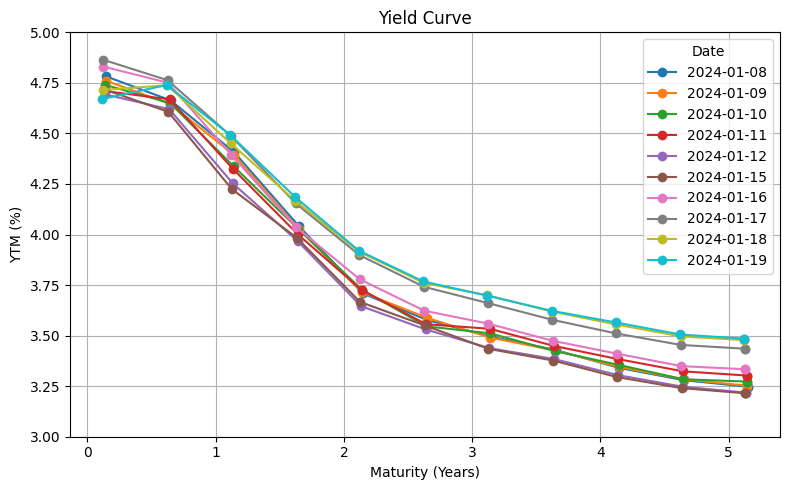

In [1168]:
# Visualization of the Yield Curve
plt.figure(figsize=(8, 5))

for date in dates:

    # Filter the rows for a specific date
    bonds_filtered = bonds[bonds['date'] == date]
    maturities = bonds_filtered['TTM']
    YTM = bonds_filtered['YTM']*100
    plt.plot(maturities, YTM, marker='o', linestyle='-', label=date) 

# Add title and labels
plt.title('Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('YTM (%)')
plt.ylim(3,5)
plt.legend(title='Date',loc='upper right')

# Display the plot
plt.grid(True) 
plt.tight_layout()
plt.show()

**Interpolation Method**  
Interpolate the rate $r$ at a time $t$  given  $ t_1 \leq t \leq t_2$:  
$ r(t) = \frac{t_2-t}{t_2-t_1} \cdot r(t_1) + \frac{t-t_1}{t_2-t_1} \cdot r(t_2) $

In [1169]:
# interpolation function
def interpolation(t, r1, t1, r2, t2):
    return ((t2-t)/(t2-t1))*r1 + ((t-t1)/(t2-t1))*r2

In [1170]:
# interpolate the 1-5 year yield curve
interpolated_yields = []

years = [i for i in range(1,6)]
for date in dates:
    bonds_filtered = bonds[bonds['date'] == date]
    maturities = list(bonds_filtered['TTM'])
    YTM = list(bonds_filtered['YTM']*100)

    for i in range(1, len(years)+1):
        year = i
        interpolated_yield = interpolation(i, YTM[i*2-1], maturities[i*2-1], YTM[i*2], maturities[i*2])
        interpolated_yields.append([date, year, interpolated_yield])

# Convert the list to a DataFrame
int_YTM_df = pd.DataFrame(interpolated_yields, columns=['date', 'year', 'interpolated_yield'])
int_YTM_df = int_YTM_df.pivot(index='year', columns='date', values='interpolated_yield')
int_YTM_df


date,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
year,,,,,,,,,,
1,4.481448,4.465890,4.425563,4.418350,4.351849,4.321663,4.482296,4.553822,4.519020,4.548787
2,3.806470,3.804623,3.811698,3.801553,3.732805,3.747336,3.842610,3.960330,3.974883,3.982012
3,3.518833,3.518158,3.521038,3.540092,3.463094,3.464161,3.575280,3.680810,3.714170,3.714112
4,3.366371,3.368657,3.374784,3.401793,3.326440,3.316177,3.427153,3.527403,3.570728,3.578934
5,3.256879,3.261599,3.275992,3.308502,3.226105,3.221541,3.337697,3.439985,3.482118,3.489994


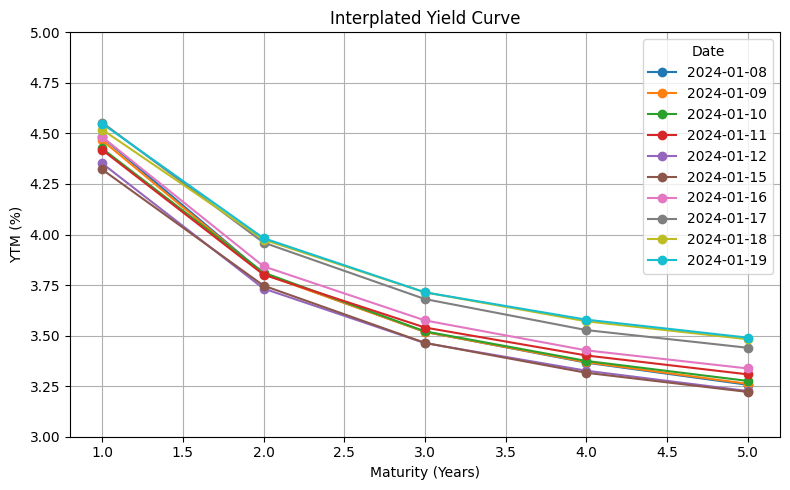

In [1171]:
# Visualization of the Interpolated Yield Curve
plt.figure(figsize=(8, 5))

for date in int_YTM_df.columns:
    plt.plot(int_YTM_df.index, int_YTM_df[date], marker='o', linestyle='-', label=date) 

# Add title and labels
plt.title('Interplated Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('YTM (%)')
plt.ylim(3,5)
plt.legend(title='Date',loc='upper right')

# Display the plot
plt.grid(True) 
plt.tight_layout()
plt.show()

**Section 2.2 4(b)**
1. Pseudo-code (explaination of an algorithm): how to derive the spot curve with terms ranging from 1-5 years from your chosen bonds 
1. Provide a well-labeled plot with a 5-year spot curve corresponding to each day of data superimposed on-top of each other

In [1172]:
# Bootstrap spot curve for a specific date
def bootstrap_spot_curve(date, bonds):

    filtered_bonds = bonds[bonds['date'] == date].copy()
    date = pd.to_datetime(date)
    spot_rates = []
    time = []

    bonds_sorted = filtered_bonds.sort_values(by='MD')

    for i, row in bonds_sorted.iterrows():
        FV, DP, CR, LCD, TTM= 100, row['DP'], row['CR'], row['LCD'], row['TTM']

        # Similar to YTM Calculation
        coupon = CR*FV/2
        NCD = LCD + pd.DateOffset(months=6)
        w = (NCD - date).days / 365
        T = TTM * 2

        if i==0: 
            r = -np.log(DP/(FV + coupon))/TTM
            spot_rates.append(r)
            time.append(TTM)
        
        else:
             cash_flows = np.array([coupon] * int(T) + [100 + coupon])
             time_periods = np.arange(w, TTM + w, 0.5)

             def equation_to_solve(r):
                present_value = sum(cf_i * np.exp(-r_i * tp_i) for r_i, cf_i, tp_i in zip(spot_rates, cash_flows[:-1], time_periods[:-1]))
                present_value = present_value + (cash_flows[-1] * np.exp(-r * time_periods[-1]))
                return present_value - DP
             
             # Solve for r
             r_initial_guess = 0.05
             solution = root(equation_to_solve, r_initial_guess)
             r = solution.x[0]
             spot_rates.append(r) 
             time.append(TTM)
    
    filtered_bonds['Spot'] = spot_rates
    return filtered_bonds, spot_rates, time
    

In [1173]:
# Initialize if not present
bonds['Spot'] = np.nan 
spot_dictionary = {}

for date in dates: 
    new_info, spot_rates, time = bootstrap_spot_curve(date, bonds)
    spot_dictionary[date]=[time, spot_rates]
    bonds.update(new_info[['Spot']])

bonds

,date,ISIN,MD,CR,CP,LCD,AI,DP,TTM,YTM,Spot
11,2024-01-08,CA135087J546,2024-03-01,0.0225,99.630,2023-09-01,0.795205,100.425205,0.145205,0.047823,0.047823
12,2024-01-09,CA135087J546,2024-03-01,0.0225,99.640,2023-09-01,0.801370,100.441370,0.142466,0.047613,0.047613
13,2024-01-10,CA135087J546,2024-03-01,0.0225,99.650,2023-09-01,0.807534,100.457534,0.139726,0.047395,0.047395
14,2024-01-11,CA135087J546,2024-03-01,0.0225,99.661,2023-09-01,0.813699,100.474699,0.136986,0.047095,0.047095
15,2024-01-12,CA135087J546,2024-03-01,0.0225,99.670,2023-09-01,0.819863,100.489863,0.134247,0.046932,0.046932
...,...,...,...,...,...,...,...,...,...,...,...
368,2024-01-15,CA135087Q988,2029-03-01,0.0400,103.552,2023-09-01,1.490411,105.042411,5.128767,0.032149,0.031883
369,2024-01-16,CA135087Q988,2029-03-01,0.0400,102.974,2023-09-01,1.501370,104.475370,5.126027,0.033338,0.033084
370,2024-01-17,CA135087Q988,2029-03-01,0.0400,102.483,2023-09-01,1.512329,103.995329,5.123288,0.034354,0.034098
371,2024-01-18,CA135087Q988,2029-03-01,0.0400,102.279,2023-09-01,1.523288,103.802288,5.120548,0.034776,0.034534


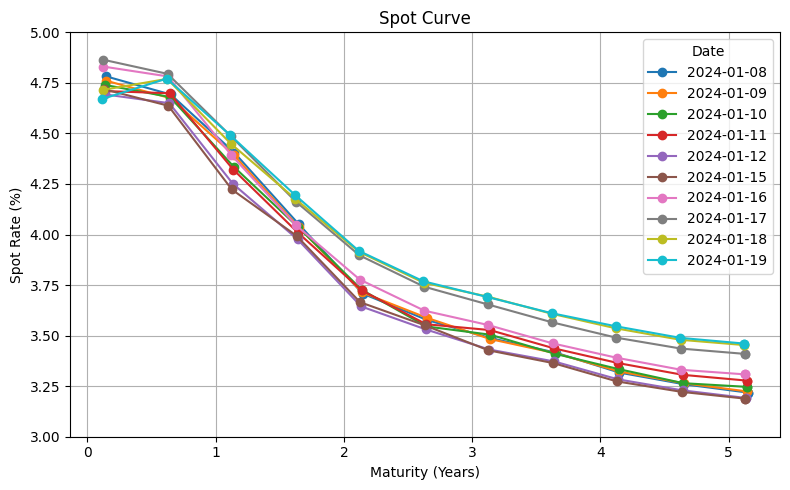

In [1174]:
# Visualization of the Spot Curve
plt.figure(figsize=(8, 5))

for date in dates:

    # Filter the rows for a specific date
    bonds_filtered = bonds[bonds['date'] == date]
    maturities = bonds_filtered['TTM']
    spot = bonds_filtered['Spot']*100
    plt.plot(maturities, spot, marker='o', linestyle='-', label=date) 

# Add title and labels
plt.title('Spot Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.ylim(3,5)
plt.legend(title='Date',loc='upper right')

# Display the plot
plt.grid(True) 
plt.tight_layout()
plt.show()

In [1175]:
# interpolate the 1-5 year yield curve
interpolated_spots = []

years = [i for i in range(1,6)]
for date in dates:
    bonds_filtered = bonds[bonds['date'] == date]
    maturities = list(bonds_filtered['TTM'])
    spot = list(bonds_filtered['Spot']*100)

    for i in range(1, len(years)+1):
        year = i
        interpolated_spot = interpolation(i, spot[i*2-1], maturities[i*2-1], spot[i*2], maturities[i*2])
        interpolated_spots.append([date, year, interpolated_spot])

# Convert the list to a DataFrame
int_spot_df = pd.DataFrame(interpolated_spots, columns=['date', 'year', 'interpolated_spot'])
int_spot_df = int_spot_df.pivot(index='year', columns='date', values='interpolated_spot')
int_spot_df

date,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
year,,,,,,,,,,
1,4.489214,4.473516,4.432904,4.425539,4.358719,4.328027,4.488870,4.560513,4.525604,4.555394
2,3.808096,3.806225,3.813328,3.803121,3.734276,3.748742,3.843929,3.961765,3.976366,3.983429
3,3.513540,3.512867,3.516078,3.535499,3.457998,3.458866,3.570214,3.675762,3.709609,3.709325
4,3.346447,3.349071,3.356037,3.384247,3.308039,3.296984,3.408524,3.508565,3.553427,3.561724
5,3.230620,3.235775,3.251765,3.285607,3.201862,3.197027,3.314101,3.416282,3.459691,3.467544


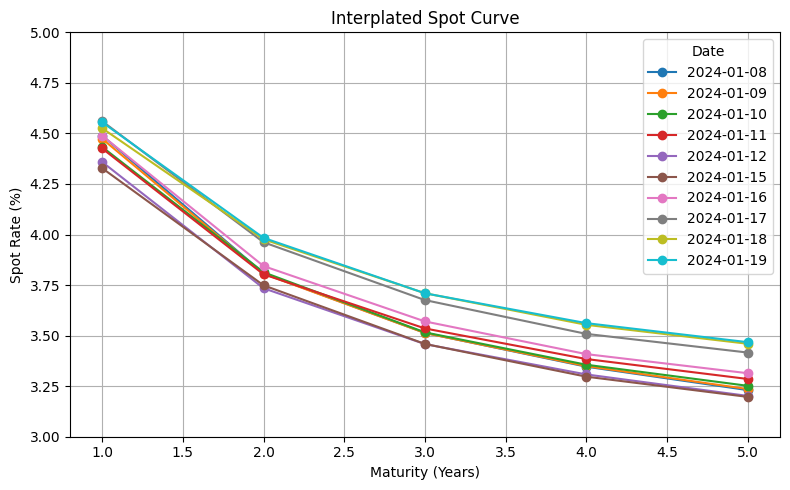

In [1176]:
# Visualization of the Interpolated Spot Curve
plt.figure(figsize=(8, 5))

for date in int_spot_df.columns:
    plt.plot(int_spot_df.index, int_spot_df[date], marker='o', linestyle='-', label=date) 

# Add title and labels
plt.title('Interplated Spot Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.ylim(3,5)
plt.legend(title='Date',loc='upper right')

# Display the plot
plt.grid(True) 
plt.tight_layout()
plt.show()

**Section 2.2 4(c)**
1. Pseudo-code: how to derive the 1-year forward curve with terms ranging from 2-5 years from your chosen bonds
1. The forward curve: with the fist point being the 1yr-1yr forward rate and the last point being the 1yr-4yr rate
1. Provide a well-labeled plot with a forward curve corresponing to each day of data superimposed on-top of each other.


Idea: To calculate the forward curve from the spot curve   
$ F_{t,t+n}$: forward rate from time $t$ to  $t+n$  
$ F_{t,t+n} = \frac{(S_{(t+n)} \times (t+n) - (S_t \times t))}{n} $  
$ S_{t+1} $ : the continuously compounded spot rate for the period ending in (t+n)  
$ S_{t} $ : the continuously compounded spot rate for the period ending in (t)  


In [1177]:
def compute_forward_curve(interpolated_spot, n, t):
    S_t = interpolated_spot[t-1]
    S_tn = interpolated_spot[t + n -1]
    return (S_tn*(t+n) - S_t*t)/n

In [1178]:
forward_years = [i for i in range(1, 5)]
forward_data = []

for date in int_spot_df.columns:
    forwards = []
    interpolated_spot = int_spot_df[date].values

    for i in forward_years:
        forward = compute_forward_curve(interpolated_spot, n=1, t=i)
        forwards.append(forward)
    forward_data.append(forwards)

forward_df = pd.DataFrame(forward_data, columns=forward_years, index=int_spot_df.columns).T
forward_df

date,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
1,3.126978,3.138934,3.193751,3.180703,3.109833,3.169458,3.198988,3.363018,3.427127,3.411463
2,2.924429,2.926152,2.921578,3.000255,2.905443,2.879112,3.022785,3.103754,3.176095,3.161116
3,2.845168,2.857685,2.875913,2.930489,2.858161,2.811338,2.923454,3.006975,3.084880,3.118922
4,2.767313,2.782588,2.834677,2.891050,2.777155,2.797202,2.936407,3.047152,3.084749,3.090826


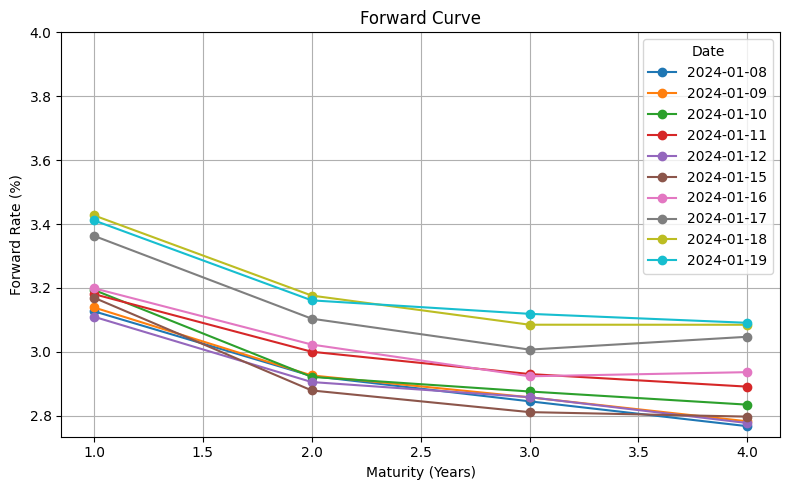

In [1179]:
# Visualization of the Forward Curve
plt.figure(figsize=(8, 5))

for column in forward_df.columns:
    plt.plot(forward_df.index, forward_df[column], label=column, marker='o', linestyle='-')

# Add title and labels
plt.title('Forward Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward Rate (%)')
plt.ylim(None,4)
plt.legend(title='Date',loc='upper right')

# Display the plot
plt.grid(True) 
plt.tight_layout()
plt.show()

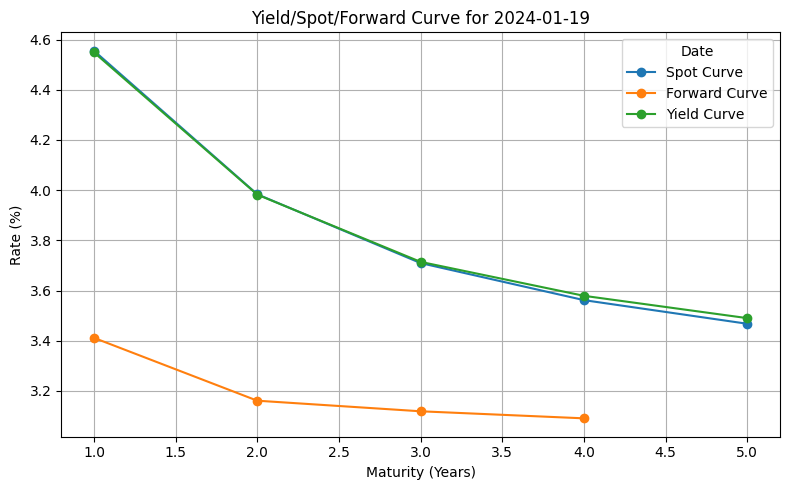

In [1180]:
# Visualization of the Yield Curve with the Spot Curve
date = '2024-01-19'

# Create the figure and axis
plt.figure(figsize=(8, 5))

# Plot Spot
plt.plot(int_spot_df.index, int_spot_df[date], marker='o', linestyle='-', label='Spot Curve') 

# Plot Forward
plt.plot(forward_df.index, forward_df[column], marker='o', linestyle='-', label= 'Forward Curve')

# Plot YTM
plt.plot(int_YTM_df.index, int_YTM_df[date], marker='o', linestyle='-', label= 'Yield Curve') 

# Add title and labels
plt.title('Yield/Spot/Forward Curve for ' + date)
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate (%)')
plt.legend(title='Date',loc='upper right')

# Display the plot
plt.grid(True) 
plt.tight_layout()
plt.show()

**Section 2.2 5**
1. Calculate two covariance matrices for the time series of daily log-returns of yield and forward rate (no spot rate))
1. First calculate the covariance matrix of the random variabledd i or i=1,...5 where each random Xi has a time series Xi,j given by
$$
X_{i,j} = \log\left(\frac{r_{i,j+1}}{r_{i,j}}\right), \quad j=1,...,9
$$

$LogReturn_{i,j} = \log(\frac{YTM_{i,j+1}}{YTM_{i,j}})$  
i = 1, . . . , 11 implies you have 11 different yield rates (for example, they could be yields for different maturities).  
j = 1, . . . , 9 suggests you are looking at a time series of 9 days for each yield rate

In [1181]:
def calculate_log_returns(series):
    log_returns = np.log(series / series.shift(1))
    return log_returns

**Covariance Matrices**
1. Please note that the first step is to calculate the daily log returns for each yield rate across the 9 days.
1. You’ll end up with a series of log returns for each i. Then, calculate the covariance matrix for these log returns. 
1. The covariance matrix will show how the returns of these different yield rates co-vary with each other over the period. 
1. In a matrix form, each element of the matrix represents the covariance between the log returns of yields i and i'

In [1182]:
int_YTM_df_T = int_YTM_df.T
log_returns_YTM = int_YTM_df_T.apply(calculate_log_returns)
log_returns_YTM.dropna(inplace=True)
log_returns_YTM

year,1,2,3,4,5
date,,,,,
2024-01-09,-0.003478,-0.000485,-0.000192,0.000679,0.001448
2024-01-10,-0.009071,0.001858,0.000818,0.001817,0.004403
2024-01-11,-0.001631,-0.002665,0.005397,0.007971,0.009875
2024-01-12,-0.015166,-0.018250,-0.021990,-0.022400,-0.025220
2024-01-15,-0.006961,0.003885,0.000308,-0.003090,-0.001416
2024-01-16,0.036495,0.025107,0.031573,0.032917,0.035421
2024-01-17,0.015831,0.030176,0.029089,0.028832,0.030186
2024-01-18,-0.007672,0.003668,0.009022,0.012208,0.012174
2024-01-19,0.006565,0.001792,-0.000015,0.002295,0.002259


In [1183]:
cov_matrix_YTM = log_returns_YTM.cov()
print("Covariance Matrixc of Log Returns (YTM):")
cov_matrix_YTM

Covariance Matrixc of Log Returns (YTM):


year,1,2,3,4,5
year,,,,,
1,0.000254,0.000193,0.000221,0.000226,0.000239
2,0.000193,0.000211,0.000228,0.000227,0.000242
3,0.000221,0.000228,0.000264,0.000270,0.000288
4,0.000226,0.000227,0.000270,0.000279,0.000297
5,0.000239,0.000242,0.000288,0.000297,0.000318


$LogReturn_{i,j} = \log(\frac{Forward_{i,j+1}}{Forward_{i,j}})$  
i = 1, . . . , 4 implies you have 4 different forward rates (1yr-1yr, 1yr-2yr, 1yr − 3yr, 1yr − 4yr).  
j = 1, . . . , 9 suggests you are looking at a time series of 9 days for each yield rate

1. The same methodology is then applied to forward rates specified (1yr-1yr, 1yr-2yr, 1yr − 3yr, 1yr − 4yr).
2. These forward rates represent the rate agreed upon now for lending or borrowing over a period starting one year from now and lasting for 1,2, 3, or 4 years, respectively.
3. You calculate log returns for these forward rates similarly and then compute the covariance matrix for these returns

In [1184]:
forward_df_T = forward_df.T
log_returns_forward = forward_df_T.apply(calculate_log_returns)
log_returns_forward.dropna(inplace=True)
log_returns_forward

,1,2,3,4
date,,,,
2024-01-09,0.003816,0.000589,0.004390,0.005505
2024-01-10,0.017313,-0.001565,0.006358,0.018546
2024-01-11,-0.004094,0.026574,0.018799,0.019692
2024-01-12,-0.022533,-0.032112,-0.024991,-0.040193
2024-01-15,0.018992,-0.009104,-0.016518,0.007193
2024-01-16,0.009274,0.048697,0.039105,0.048567
2024-01-17,0.050004,0.026434,0.028169,0.037021
2024-01-18,0.018884,0.023040,0.025578,0.012263
2024-01-19,-0.004581,-0.004727,0.010975,0.001968


In [1185]:
cov_matrix_forward = log_returns_forward.cov()
print("Covariance Matrixc of Log Returns (Forward):")
cov_matrix_forward

Covariance Matrixc of Log Returns (Forward):


,1,2,3,4
1,0.000415,0.000237,0.000202,0.000345
2,0.000237,0.000597,0.000480,0.000548
3,0.000202,0.000480,0.000434,0.000443
4,0.000345,0.000548,0.000443,0.000619


**Section 2.2 6**
1. Calculate the eigenvalues and eigenvectors of both covariance matrices, and in one sentence, explain what the first (in terms of size) eigenvalue and its associated eigenvector imply

In [1186]:
# Calculate eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_YTM)

# Sorting eigenvalues and eigenvectors by the size of eigenvalues
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Display the eigenvalue and its associated eigenvector
print("Eigenvalue:", eigenvalues)
print("Eigenvector:", eigenvectors)

# Display the largest eigenvalue and its associated eigenvector
print("Largest Eigenvalue:", eigenvalues[0])
print("Associated Eigenvector:", eigenvectors[:, 0])

Eigenvalue: [1.24672984e-03 5.91091811e-05 1.97665562e-05 7.57210932e-07
 6.50313413e-07]
Eigenvector: [[-0.40571328 -0.91155766 -0.06101746 -0.02679233 -0.00429069]
 [-0.39595032  0.12071583  0.87010793 -0.13031113  0.2336284 ]
 [-0.45798384  0.19285371  0.03145915  0.42328945 -0.75689802]
 [-0.46848825  0.21283079 -0.32991019  0.50714507  0.60760592]
 [-0.49938926  0.26832969 -0.35966463 -0.73887151 -0.05761763]]
Largest Eigenvalue: 0.0012467298376769177
Associated Eigenvector: [-0.40571328 -0.39595032 -0.45798384 -0.46848825 -0.49938926]


In [1187]:
# Calculate eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_forward)

# Sorting eigenvalues and eigenvectors by the size of eigenvalues
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Display the eigenvalue and its associated eigenvector
print("Eigenvalue:", eigenvalues)
print("Eigenvector:", eigenvectors)

# Display the largest eigenvalue and its associated eigenvector
print("Largest Eigenvalue:", eigenvalues[0])
print("Associated Eigenvector:", eigenvectors[:, 0])

Eigenvalue: [1.70312576e-03 2.84469112e-04 5.45685524e-05 2.27290717e-05]
Eigenvector: [[ 0.3350816   0.87537409  0.31519418 -0.14863763]
 [ 0.56668453 -0.36155951  0.05347589 -0.73843327]
 [ 0.47214542 -0.30628596  0.61115619  0.55655703]
 [ 0.58623176  0.0958323  -0.72407256  0.35052451]]
Largest Eigenvalue: 0.0017031257561395821
Associated Eigenvector: [0.3350816  0.56668453 0.47214542 0.58623176]
